
# Simple Predictive Analysis on CDC Diabetes Indicators dataset
**Author:** Runhe Zhang  
**Date:** 2025-10-20

**Goal:** Identify which lifestyle and health factors are most associated with diabetes (binary) and train simple models to predict diabetes.


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    RocCurveDisplay, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

RNG = 42
np.random.seed(RNG)
pd.set_option("display.max_columns", 200)


## 1) Load Dataset

In [ ]:
df = pd.read_csv("/diabetes_binary_health_indicators_BRFSS2015.csv")
print("Shape:", df.shape)
df.head()


Shape: (253680, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


## 2) Minimal EDA

Class counts:
 Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64
Class proportions:
 Diabetes_binary
0.0    0.860667
1.0    0.139333
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
Diabetes_binary,253680.0,0.139333,0.346294,0.0,0.0,0.0,0.0,1.0
HighBP,253680.0,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0
HighChol,253680.0,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0
CholCheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
Smoker,253680.0,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0
Stroke,253680.0,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0
PhysActivity,253680.0,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0
Fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0


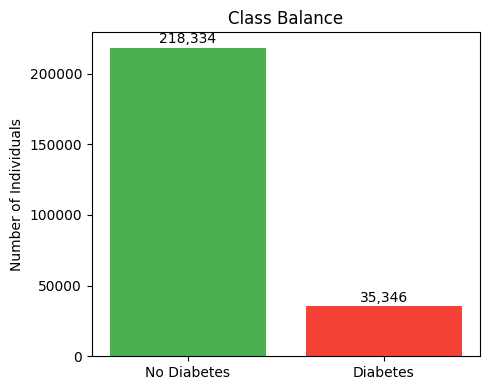

In [ ]:

target = "Diabetes_binary"
assert target in df.columns, f"{target} not found; columns: {list(df.columns)[:10]}..."

# Class balance
counts = df[target].value_counts().sort_index()
props = df[target].value_counts(normalize=True).sort_index()
print("Class counts:\n", counts)
print("Class proportions:\n", props)

# Quick numeric summary
display(df.describe().T.head(12))

# Bar chart for class balance
plt.figure(figsize=(5,4))
bars = plt.bar(["No Diabetes", "Diabetes"], counts.values, color=["#4CAF50", "#F44336"])
plt.title("Class Balance")
plt.ylabel("Number of Individuals")

# Add labels on top of bars
for bar, value in zip(bars, counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, value + 1000, f"{value:,}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()



## 3) Train/Test Split

In [ ]:

y = df[target].astype(int)
X = df.drop(columns=[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RNG
)
X_train.shape, X_test.shape


((202944, 21), (50736, 21))

## 4) Models: Logistic Regression and Random Forest

In [ ]:

def metrics(y_true, y_pred, y_score):
    return pd.Series({
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_score),
    }).round(3)

# Logistic Regression (balanced)
logit = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RNG, n_jobs=-1))
])

# Random Forest
rf = RandomForestClassifier(
    n_estimators=400, class_weight="balanced_subsample", random_state=RNG, n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
logit_auc_cv = cross_val_score(logit, X_train, y_train, cv=cv, scoring="roc_auc")
rf_auc_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="roc_auc")

print(f"LogReg CV ROC-AUC: {logit_auc_cv.mean():.3f} ± {logit_auc_cv.std():.3f}")
print(f"RF     CV ROC-AUC: {rf_auc_cv.mean():.3f} ± {rf_auc_cv.std():.3f}")

# Fit & test
logit.fit(X_train, y_train)
rf.fit(X_train, y_train)

proba_logit = logit.predict_proba(X_test)[:,1]
pred_logit = (proba_logit >= 0.5).astype(int)

proba_rf = rf.predict_proba(X_test)[:,1]
pred_rf = (proba_rf >= 0.5).astype(int)

m_logit = metrics(y_test, pred_logit, proba_logit)
m_rf = metrics(y_test, pred_rf, proba_rf)

print("\nTest metrics — Logistic Regression:\n", m_logit.to_string())
print("\nTest metrics — Random Forest:\n", m_rf.to_string())


LogReg CV ROC-AUC: 0.823 ± 0.001
RF     CV ROC-AUC: 0.801 ± 0.002

Test metrics — Logistic Regression:
 accuracy     0.732
precision    0.311
recall       0.761
f1           0.441
roc_auc      0.820

Test metrics — Random Forest:
 accuracy     0.857
precision    0.460
recall       0.157
f1           0.235
roc_auc      0.796


## 5) ROC Curve

<Figure size 640x480 with 0 Axes>

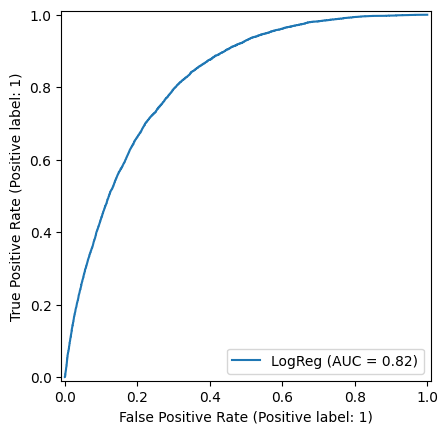

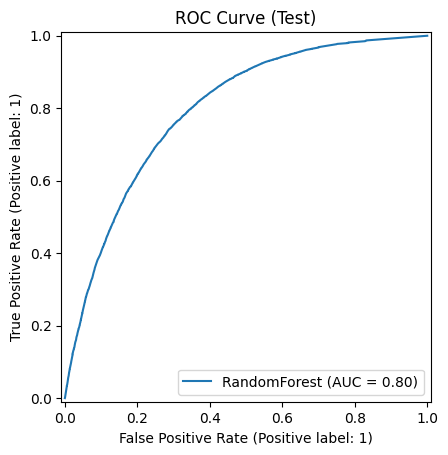

In [13]:

fig = plt.figure()
RocCurveDisplay.from_predictions(y_test, proba_logit, name="LogReg")
RocCurveDisplay.from_predictions(y_test, proba_rf, name="RandomForest")
plt.title("ROC Curve (Test)")
plt.show()


## 6) Confusion Matrices (Threshold = 0.5)

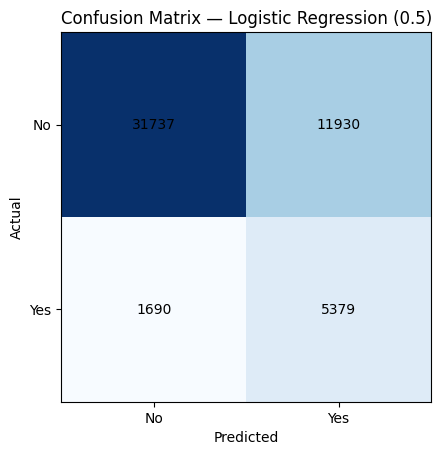

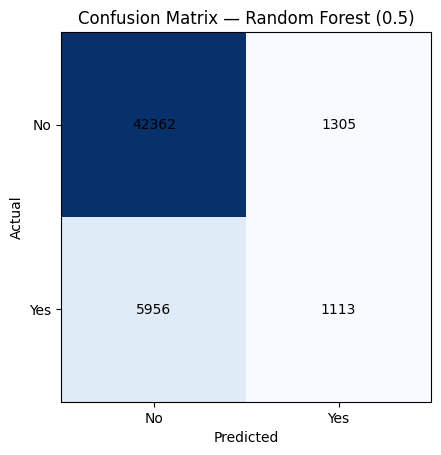

In [14]:

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["No","Yes"]); ax.set_yticklabels(["No","Yes"])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    ax.set_title(title)
    plt.show()

plot_cm(y_test, pred_logit, "Confusion Matrix — Logistic Regression (0.5)")
plot_cm(y_test, pred_rf, "Confusion Matrix — Random Forest (0.5)")


## 7) What matters most? (Top-10 features)

,RF_importance
BMI,0.172112
Age,0.127873
GenHlth,0.105603
Income,0.084473
HighBP,0.076085
PhysHlth,0.070345
Education,0.058939
MentHlth,0.053733
HighChol,0.039110
Smoker,0.028003


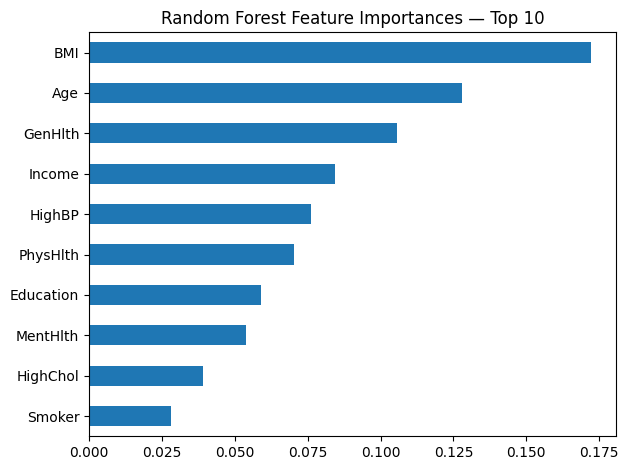

,LogReg_coef
GenHlth,0.618315
BMI,0.490640
Age,0.457200
HighBP,0.364514
HighChol,0.287354
CholCheck,0.248785
HvyAlcoholConsump,-0.173115
Sex,0.139243
Income,-0.119439
HeartDiseaseorAttack,0.073098


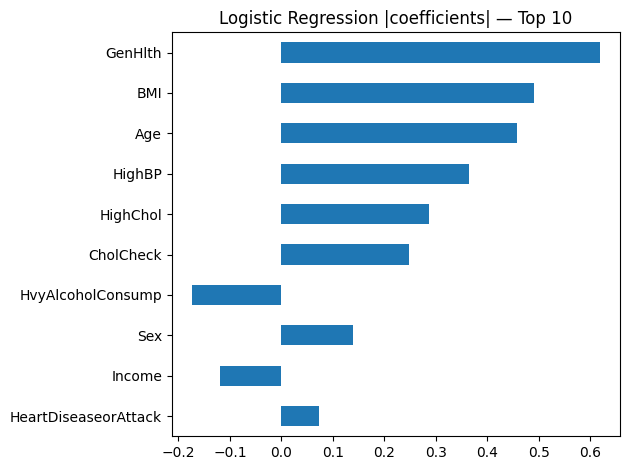

In [15]:

# RF importances (Top 10)
rf_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)
display(rf_imp.to_frame("RF_importance"))

plt.figure()
rf_imp.iloc[::-1].plot(kind="barh")
plt.title("Random Forest Feature Importances — Top 10")
plt.tight_layout()
plt.show()

# Logistic coefficients (absolute, Top 10)
coef = pd.Series(logit.named_steps["clf"].coef_[0], index=X_train.columns)
coef_top = coef.reindex(coef.abs().sort_values(ascending=False).head(10).index)
display(coef_top.to_frame("LogReg_coef"))

plt.figure()
coef_top.iloc[::-1].plot(kind="barh")
plt.title("Logistic Regression |coefficients| — Top 10")
plt.tight_layout()
plt.show()



## 8) Summary (Copy these bullets to your 3–5 page PDF)
- **Models:** Logistic Regression (balanced) and Random Forest
- **Performance (example):** ROC-AUC ~0.7–0.8 (your exact value will appear above)
- **Top factors (typical):** BMI, Age, General Health, Difficulty Walking, HighBP
- **Takeaway:** Lifestyle and general health indicators are strongly associated with diabetes; simple models provide reasonable screening performance.
- **Limitations:** Self-reported survey, class imbalance, minimal tuning; not causal.
